In [43]:
import numpy as np
from PIL import Image
import glob
import os
def load_image(dataset_dir, size=(250,250)):
    X1=[]   # list to store the image data
    y1=[]   # list to store the labels of the image dataset
    #there are two folders in my dataset "abnormal->1" adn "normal->0"
    classes={
        "normal" :0,
        "abnormal": 1
    }
    # entering into the each class inside the folder
    for class_name, class_label in classes.items():
        folder = os.path.join(dataset_dir,class_name)
        image_paths = glob.glob(folder+"/*.png")
        for path in image_paths:
            img = Image.open(path)
            # converting images to grayscale
            img = img.convert("L")  # using this method converting all the images to greyscale images
            #resizing all images
            img = img.resize(size)
            #converting all images to array
            arr = np.array(img, dtype=np.float32)/255.0
            #flattening all the images
            arr = arr.flatten()
            X1.append(arr)
            y1.append(class_label)
    X = np.array(X1)
    Y = np.array(y1)
    return X,Y


In [44]:
X,Y = load_image("C:/Users/HP/Downloads/dataset-fro-programming&mathsforAI/spectrogramprocessedata/dataset")

In [45]:
def train_test_split(X, y, test_ratio=0.2):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    split = int(N * (1 - test_ratio))

    train_idx = idx[:split]
    test_idx  = idx[split:]

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]


In [46]:
X_train, y_train, X_test, y_test = train_test_split(X, Y, test_ratio=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(4188, 62500) (4188,)
(1047, 62500) (1047,)


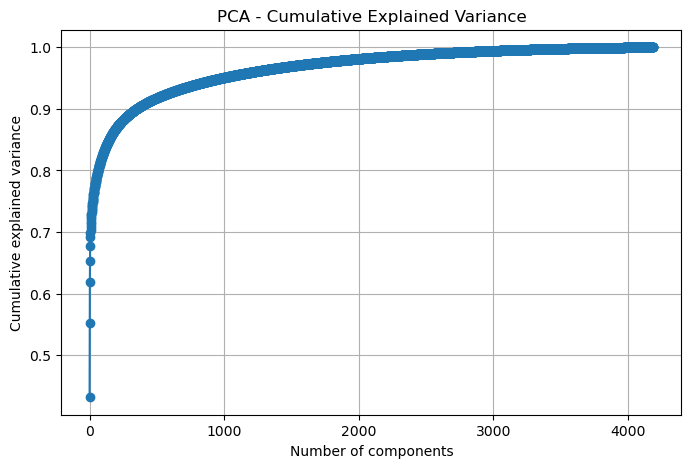

Number of components to retain 95% variance: 1939
Shape of X_train after PCA: (4188, 1939)


In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Suppose X_train is your flattened image data: shape (num_samples, num_features)
# Step 1: Standardize features (optional for PCA)
X_train_std = X_train - np.mean(X_train, axis=0)

# Step 2: Fit PCA
pca = PCA()  # fit all components first to see variance
pca.fit(X_train_std)

# Step 3: Explained variance
explained_variance = pca.explained_variance_ratio_

# Step 4: Cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Step 5: Plot cumulative variance
plt.figure(figsize=(8,5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Optional: choose number of components to explain e.g., 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.98) + 1
print(f"Number of components to retain 95% variance: {n_components_95}")

# Step 6: Transform dataset using selected number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_std)

print("Shape of X_train after PCA:", X_train_pca.shape)


Building layers of neural network where :
1. optimzer: Adam Optimizer
2. Architecture of the neural network = 40,000 → 8,000 → 4,000 → 2,000 → 1,000 → 500 → 256 → 128 → 2
3. Dropout = 0.2(20%)

In [82]:
print(X_train_pca.shape, y_train.shape)

(4188, 3) (4188,)


In [32]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim).astype(np.float32)*0.01
        self.b = np.zeros((out_dim,))

        # Adam parameters
        self.mW = np.zeros_like(self.W)
        self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)
        self.t = 0  # timestep

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad_out, l2=0.0):
        self.dW = self.x.T @ grad_out + l2*self.W
        self.db = np.sum(grad_out, axis=0)
        return grad_out @ self.W.T

    def update_adam(self, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        # Update moving averages
        self.mW = beta1*self.mW + (1-beta1)*self.dW
        self.vW = beta2*self.vW + (1-beta2)*(self.dW**2)
        self.mb = beta1*self.mb + (1-beta1)*self.db
        self.vb = beta2*self.vb + (1-beta2)*(self.db**2)

        # Bias correction
        mW_hat = self.mW / (1 - beta1**self.t)
        vW_hat = self.vW / (1 - beta2**self.t)
        mb_hat = self.mb / (1 - beta1**self.t)
        vb_hat = self.vb / (1 - beta2**self.t)

        # Parameter update
        self.W -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
        self.b -= lr * mb_hat / (np.sqrt(vb_hat) + eps)


In [31]:
class ReLU:
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_out):
        return grad_out * self.mask

In [33]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(pred, y):
    N = y.shape[0]
    p = pred[range(N), y]
    return -np.mean(np.log(p + 1e-12))

def softmax_backward(pred, y):
    grad = pred.copy()
    grad[np.arange(len(y)), y] -= 1
    return grad / len(y)


In [121]:
class Dropout:
    def __init__(self, p=0.4):
        self.p = p
        self.mask = None
        self.training = True  # controls if dropout is applied

    def forward(self, x):
        if self.training:
            keep = 1 - self.p
            self.mask = (np.random.rand(*x.shape) < keep) / keep
            return x * self.mask
        else:
            return x

    def backward(self, grad_out):
        if self.training:
            return grad_out * self.mask
        else:
            return grad_out


In [125]:
class SimpleNN:
    def __init__(self, input_dim, output_dim=2, dropout_p=0.2):
        # Gradual halving network
        self.layers = []
        self.activations = []
        self.dropouts = []

        dims = [input_dim, 128,output_dim]

        for i in range(len(dims)-1):
            self.layers.append(Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:  # all hidden layers
                self.activations.append(ReLU())
                self.dropouts.append(Dropout(p=dropout_p))
            else:
                self.activations.append(None)  # output layer has no activation
                self.dropouts.append(None)

    def forward(self, x, training=True):
        out = x
        for i in range(len(self.layers)):
            out = self.layers[i].forward(out)
            if self.activations[i] is not None:
                out = self.activations[i].forward(out)
            if self.dropouts[i] is not None:
                out = self.dropouts[i].forward(out)  # pass training flag
        return out


    def backward(self, grad, l2=0.0):
        for i in reversed(range(len(self.layers))):
            if self.dropouts[i] is not None:
                grad = self.dropouts[i].backward(grad)
            if self.activations[i] is not None:
                grad = self.activations[i].backward(grad)
            grad = self.layers[i].backward(grad, l2=l2)
        return grad

    def update(self, lr):
        for layer in self.layers:
            layer.update_adam(lr)

    def predict(self, X):
        logits = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


In [92]:
def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes=['normal', 'abnormal']):
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # write numbers inside boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [93]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [115]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def plot_metrics(history):
    epochs = range(1, len(history["loss"])+1)
    
    plt.figure(figsize=(16,5))
    
    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history["loss"], label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    
    # Precision / Recall / F1
    plt.subplot(1,3,3)
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1 vs Epoch")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def train(model, X_train, y_train, X_test, y_test, lr=0.01, epochs=20, l2=0.0):

    # Storage dictionary for plots
    history = {
        "loss": [],
        "train_acc": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for epoch in range(epochs):

        # ----- Forward -----
        logits = model.forward(X_train, training=True)
        probs = softmax(logits)

        # ----- Loss -----
        loss = cross_entropy(probs, y_train)
        loss += (l2/2) * sum(np.sum(layer.W**2) for layer in model.layers)


        # ----- Backward -----
        grad = softmax_backward(probs, y_train)
        model.backward(grad, l2=l2)

        # ----- Update -----
        model.update(lr)

        # ----- Train Accuracy -----
        train_preds = model.predict(X_train)
        train_acc = accuracy(y_train, train_preds)

        # ----- Test Accuracy -----
        test_preds = model.predict(X_test)
        test_acc = accuracy(y_test, test_preds)

        # ---- Classification Metrics (Test Set) ----
        prec = precision_score(y_test, test_preds, average='macro')
        rec  = recall_score(y_test, test_preds, average='macro')
        f1   = f1_score(y_test, test_preds, average='macro')

        # Save to history for plotting
        history["loss"].append(loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1)

        print(f"Epoch {epoch+1}/{epochs}  Loss={loss:.4f}  "
              f"TrainAcc={train_acc:.4f}  TestAcc={test_acc:.4f}  "
              f"Prec={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

    # ===== FINAL EVALUATION =====
    final_train_preds = model.predict(X_train)
    final_test_preds = model.predict(X_test)

    final_train_acc = accuracy(y_train, final_train_preds)
    final_test_acc  = accuracy(y_test, final_test_preds)

    print("\n=== Final Accuracy ===")
    print(f"Train Accuracy : {final_train_acc:.4f}")
    print(f"Test Accuracy  : {final_test_acc:.4f}")

    # FIX: final_preds → final_test_preds
    cm = confusion_matrix(y_test, final_test_preds)
    print("\nConfusion Matrix:\n", cm)

    plot_confusion_matrix(cm)

    return history


In [101]:
def model_summary(model):
    print("Layer (type)        Input → Output       # Parameters")
    print("-"*50)
    total_params = 0
    for i, layer in enumerate(model.layers):
        in_dim, out_dim = layer.W.shape
        params = in_dim * out_dim + out_dim
        total_params += params
        layer_type = "Linear"
        print(f"{i+1:2d} ({layer_type:<6})     {in_dim} → {out_dim:<6}     {params}")
    print("-"*50)
    print(f"Total parameters: {total_params}")


In [127]:
model_summary(model)

Layer (type)        Input → Output       # Parameters
--------------------------------------------------
 1 (Linear)     1939 → 128        248320
 2 (Linear)     128 → 2          258
--------------------------------------------------
Total parameters: 248578


In [126]:
model = SimpleNN(input_dim=X_train_pca.shape[1], output_dim=2, dropout_p=0.4)

Epoch 1/90  Loss=0.6928  TrainAcc=0.6543  TestAcc=0.6122  Prec=0.6324  Recall=0.6124  F1=0.5971
Epoch 2/90  Loss=0.6858  TrainAcc=0.7044  TestAcc=0.6523  Prec=0.6956  Recall=0.6526  F1=0.6322
Epoch 3/90  Loss=0.6785  TrainAcc=0.7297  TestAcc=0.6514  Prec=0.7069  Recall=0.6516  F1=0.6265
Epoch 4/90  Loss=0.6716  TrainAcc=0.7596  TestAcc=0.6724  Prec=0.7228  Recall=0.6726  F1=0.6529
Epoch 5/90  Loss=0.6632  TrainAcc=0.7858  TestAcc=0.6905  Prec=0.7342  Recall=0.6908  F1=0.6756
Epoch 6/90  Loss=0.6546  TrainAcc=0.8178  TestAcc=0.7307  Prec=0.7691  Recall=0.7308  F1=0.7208
Epoch 7/90  Loss=0.6447  TrainAcc=0.8436  TestAcc=0.7182  Prec=0.7510  Recall=0.7184  F1=0.7089
Epoch 8/90  Loss=0.6343  TrainAcc=0.8520  TestAcc=0.7402  Prec=0.7617  Recall=0.7403  F1=0.7348
Epoch 9/90  Loss=0.6231  TrainAcc=0.8680  TestAcc=0.7545  Prec=0.7699  Recall=0.7547  F1=0.7510
Epoch 10/90  Loss=0.6106  TrainAcc=0.8859  TestAcc=0.7717  Prec=0.7860  Recall=0.7718  F1=0.7689
Epoch 11/90  Loss=0.5979  TrainAcc=0.89

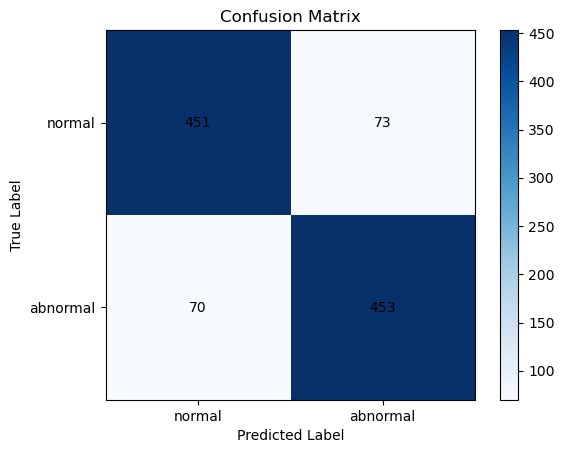

In [128]:
history = train(
    model, 
    X_train_pca, y_train, 
    X_test_pca, y_test,
    lr=0.001,       # learning rate
    epochs=90,      # number of epochs
    l2=0.00      # L2 regularization strength

)


In [84]:
X_test_std = X_test - np.mean(X_train, axis=0)  # use train mean
X_test_pca = pca.transform(X_test_std)


In [85]:
print(X_test_pca.shape)

(1047, 1939)


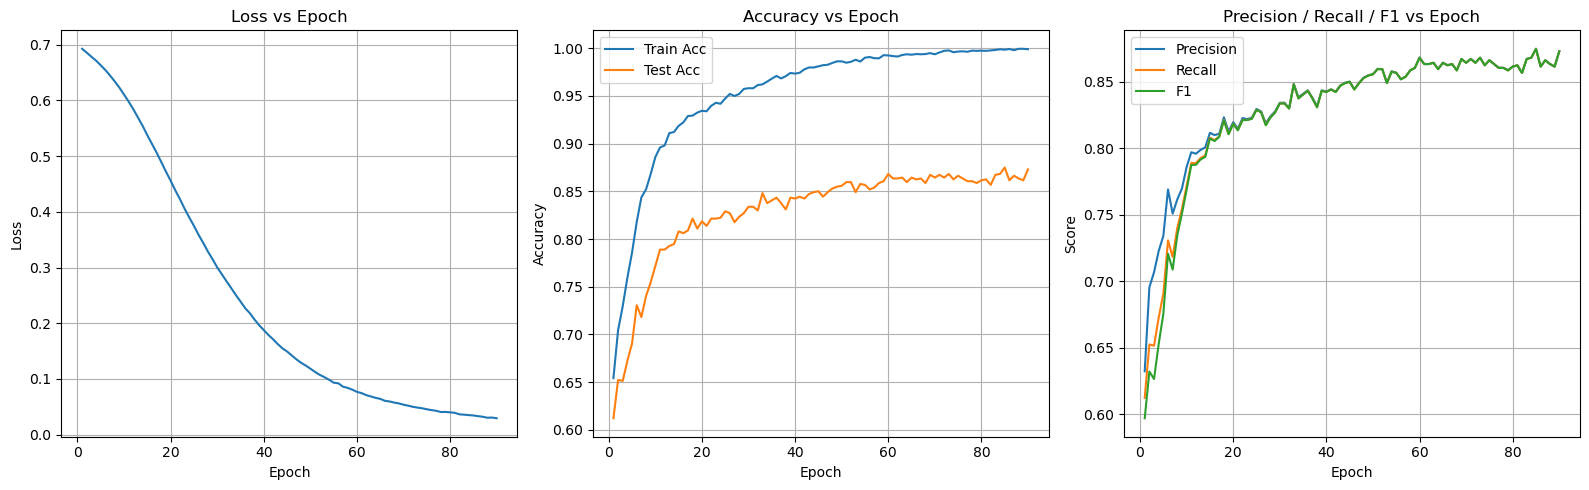

In [129]:
plot_metrics(history)
